Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 39, 64)            388928    
_________________________________________________________________
flatten_39 (Flatten)         (None, 2496)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 250)               624250    
_________________________________________________________________
dense_79 (Dense)             (None, 3)                 753       
Total params: 1,013,931
Trainable params: 1,013,931
Non-trainable params: 0
_________________________________________________________________
Train on 2399 samples, validate on 600 samples
Epoch 1/20
2399/2399 [==============================] - 1s 436us/sample - loss: 1.0695 - acc: 0.4352 - val_loss: 1.0603 - val_acc: 0.4350
Epoch 2/20
2399/2399 [==============================] - 

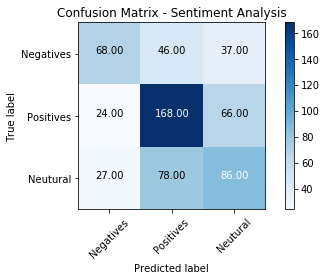

{'0': {'precision': 0.5714285714285714, 'recall': 0.4503311258278146, 'f1-score': 0.5037037037037037, 'support': 151}, '1': {'precision': 0.5753424657534246, 'recall': 0.6511627906976745, 'f1-score': 0.610909090909091, 'support': 258}, '2': {'precision': 0.455026455026455, 'recall': 0.450261780104712, 'f1-score': 0.4526315789473684, 'support': 191}, 'accuracy': 0.5366666666666666, 'macro avg': {'precision': 0.5339324974028169, 'recall': 0.5172518988767337, 'f1-score': 0.522414791186721, 'support': 600}, 'weighted avg': {'precision': 0.5360568722669179, 'recall': 0.5366666666666666, 'f1-score': 0.5335440604879201, 'support': 600}}


In [102]:
import numpy as np 
import pandas as pd 
import re
import nltk
from sklearn.metrics import confusion_matrix   
import itertools 
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
from dataScript import getDataset
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import accuracy_score
from snowballstemmer import TurkishStemmer
import random
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.preprocessing import sequence
REPEAT = 2

def preprocces_Text(text, is_mlp, stop):
    processed_features = []
    tt = TweetTokenizer()
    turkStem=TurkishStemmer()   
    for sentence in range(0, len(text)):
        processed_feature = re.sub(r'\s\'\s', '\'', str(text[sentence]))
        processed_feature= re.sub(r'[.!?:)(;,\'\"\[\]]', ' ', processed_feature)
        processed_feature= re.sub(r'\d', '', processed_feature)
        processed_feature = processed_feature.lower()
        stemmed_words = []
        for w in tt.tokenize(processed_feature):
            w = turkStem.stemWord(w)
            stemmed_words.append(w)
        processed_feature = ' '.join([str(elem) for elem in stemmed_words])     
        processed_feature= re.sub(r'ü', 'u', processed_feature)
        processed_feature= re.sub(r'ö', 'o', processed_feature)
        processed_feature= re.sub(r'ı', 'i', processed_feature)
        processed_feature= re.sub(r'ğ', 'g', processed_feature)
        processed_feature= re.sub(r'ş', 's', processed_feature)
        processed_feature= re.sub(r'ç', 'c', processed_feature)
        processed_feature = re.sub(r'#(\S+)', r' \1 ', processed_feature)
        processed_feature = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', processed_feature)
        processed_feature = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', processed_feature)
        processed_feature = re.sub(r'(<3|:\*)', ' EMO_POS ', processed_feature)
        processed_feature = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', processed_feature)
        processed_feature = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', processed_feature)
        processed_feature = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', processed_feature)
        # Convert more than 2 letter repetitions to 2 letter
        processed_feature = re.sub(r'(.)\1+', r'\1\1', processed_feature)
        if is_mlp:
            processed_features.append(filter_stop_words(processed_feature, stop))
        else:
            processed_features.append(processed_feature)
    return processed_features

def data_analayzer(data):
    data.Sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

def get_external_stopwords():
    f = open("stop_words.txt", "r", encoding='utf8')
    stop = []
    for x in f:
        stop.append(x.replace('\n',''))
    f.close()    
    ss = []
    for i in range(0, len(stop)):
        s = str(stop[i])
        s = s.lower()
        s= re.sub(r'ü', 'u', s)
        s= re.sub(r'ö', 'o', s)
        s= re.sub(r'ı', 'i', s)
        s= re.sub(r'ğ', 'g', s)
        s= re.sub(r'ç', 'c', s)
        s= re.sub(r'ş', 's', s)
        ss.append(s)
    return ss

def get_cm(y_test,y_predict):
    cm = confusion_matrix(y_test,y_predict)
    #plot_cm(cm)
    return cm

def get_c_report(y_test,y_predict):
    #print(classification_report(y_test,y_predict))
    cr = classification_report(y_test,y_predict,output_dict=True)
    return cr    


def plot_cm(cm):
    classes = ["Negatives", "Positives","Neutural"]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Sentiment Analysis")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    text_format = '05.2f'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment="center",
                color="white" if cm[row, column] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def svm_model(stop, processed_features, labels):
    vectorizer = TfidfVectorizer (max_features=2500, min_df=5, max_df=0.4, stop_words=stop)
    processed_features = vectorizer.fit_transform(processed_features)  
    pd.DataFrame(
    processed_features.todense(),
    columns=vectorizer.get_feature_names())  
    X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=1)
    model = svm.SVC(kernel='rbf')
    model.fit(X_train, y_train) 
    predicted_sentiment = model.predict(X_test)
    #print(accuracy_score(y_test, predicted_sentiment))    
    c_report = get_c_report(y_test, predicted_sentiment)
    cm = get_cm(y_test, predicted_sentiment)
    return cm, c_report

def wordcloud_draw(data,stop, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=stop,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def plot_text(text, labels, stop):
    pos = []
    neg = []
    nut = []
    for i in range(0, len(text)):
        if labels[i] == 0:
            pos.append(text[i])
        elif labels[i] == 1:
            neg.append(text[i])
        else:
            nut.append(text[i])
    print('Positive Words:')
    wordcloud_draw(pos,stop,'white')
    print('Negative Words:')
    wordcloud_draw(neg,stop,'black')
    print('Neutral Words:')
    wordcloud_draw(nut,stop,'blue')

def filter_stop_words(text, stop):
    tt = TweetTokenizer()
    words = tt.tokenize(text)
    newWords = [w for w in words if not w in stop]
    text = ' '.join([str(elem) for elem in newWords])
    return text

def find_max_lenth(features):
    lenth = 0    
    for sen in features:
        words = word_tokenize(sen)
        if len(words) > lenth:
            lenth = len(words)
    return lenth


def run_svm(data):
    total_cm = []
    total_cr = []
    for i in range(REPEAT):
        data = data.sample(frac=1).reset_index(drop=True)        
        features = data.iloc[:,0].values
        labels = data.iloc[:,1].values
        stop = get_external_stopwords()
        # plot_text(features, labels, stop)
        processed_features = preprocces_Text(features)
        # plot_text(processed_features, labels, stop)
        cm, cr = svm_model(stop, processed_features, labels)
        if len(total_cm) == 0:
            total_cm = cm
        else: 
            total_cm = [[total_cm[i][j] + cm[i][j]  for j in range(len(total_cm[0]))] for i in range(len(total_cm))] 
        if len(total_cr) == 0:
            total_cr = cr
        else: 
            for key in total_cr:
                if (isinstance(total_cr[key], float)):
                    total_cr[key] = total_cr[key] + cr[key]
                else:
                    for j in total_cr[key]:
                        total_cr[key][j] = total_cr[key][j] + cr[key][j]

    total_cm = [[total_cm[i][j] / REPEAT  for j in range(len(total_cm[0]))] for i in range(len(total_cm))] 

    for key in total_cr:
                if (isinstance(total_cr[key], float)):
                    total_cr[key] = total_cr[key] / REPEAT                
                else:
                    for j in total_cr[key]:
                        total_cr[key][j] = total_cr[key][j] / REPEAT

    plot_cm(np.array(total_cm))
    print(total_cm)
    print(total_cr)

def mlp_model(processed_features, labels, lenth):
    X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=1)
    tokenizer = Tokenizer(num_words=2000)
    tokenizer.fit_on_texts(X_train)
    
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    vocab_size = len(tokenizer.word_index) + 1
    
    X_train = pad_sequences(X_train, padding='post', maxlen=lenth)
    X_test = pad_sequences(X_test, padding='post', maxlen=lenth)
    
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=lenth))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
            epochs=20, batch_size=120, verbose=1)
    predicted_sentiment = model.predict(X_test)
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy: %.2f%%" % (scores[1]*100))    
    prediction = []
    for i in range(len(predicted_sentiment)):
        max_v = -1
        index = -1
        for j in range(len(predicted_sentiment[i])):
            if predicted_sentiment[i][j] > max_v:
                max_v = predicted_sentiment[i][j]
                index = j
        if index == 0:
            prediction.append(0)
        elif index == 1:
            prediction.append(1)
        else:
            prediction.append(2)    
    c_report = get_c_report(y_test, prediction)
    cm = get_cm(y_test, prediction)
    return cm, c_report

def run_mlp(data):    
    #data = data.sample(frac=1).reset_index(drop=True)
    features = data.iloc[:,0].values
    labels = data.iloc[:,1].values
    lenth = find_max_lenth(features)    
    stop = get_external_stopwords()
    processed_features = preprocces_Text(features, True, stop)
    cm, cr = mlp_model(processed_features,labels,lenth)
    plot_cm(cm)
    print(cr)
data = getDataset()
#data_analayzer(data)
#run_svm(data)
run_mlp(data)

